# 1) Load + drop non-wearable columns

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

df = pd.read_csv("stress_factors.csv")  # change filename

# columns to drop as inputs (survey-only / subjective). Keep if you want as metadata separately.
drop_cols = [
 'blood_pressure','breathing_problem','mental_health_history',
 'extracurricular_activities',
 'bullying','safety'
]

for c in drop_cols:
    if c in df.columns:
        df = df.drop(columns=c)
        
print("Remaining columns:", df.columns.tolist())


Remaining columns: ['anxiety_level', 'self_esteem', 'depression', 'headache', 'sleep_quality', 'noise_level', 'living_conditions', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure', 'stress_level']


['anxiety_level', 'self_esteem', 'depression', 'headache', 'sleep_quality', 'noise_level', 'living_conditions', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure', 'stress_level']
(1100, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   depression                    1100 non-null   int64
 3   headache                      1100 non-null   int64
 4   sleep_quality                 1100 non-null   int64
 5   noise_level                   1100 non-null   int64
 6   living_conditions             1100 non-null   int64
 7   basic_needs                   1100 non-null   int64
 8   academic_performance          110

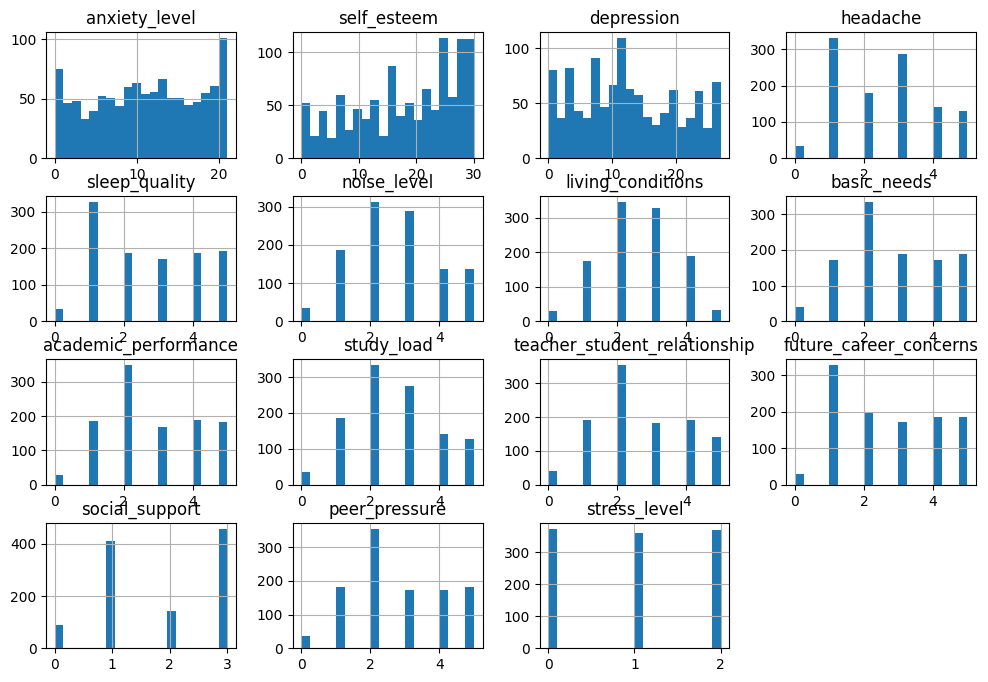

anxiety_level                   0
self_esteem                     0
depression                      0
headache                        0
sleep_quality                   0
noise_level                     0
living_conditions               0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
future_career_concerns          0
social_support                  0
peer_pressure                   0
stress_level                    0
dtype: int64


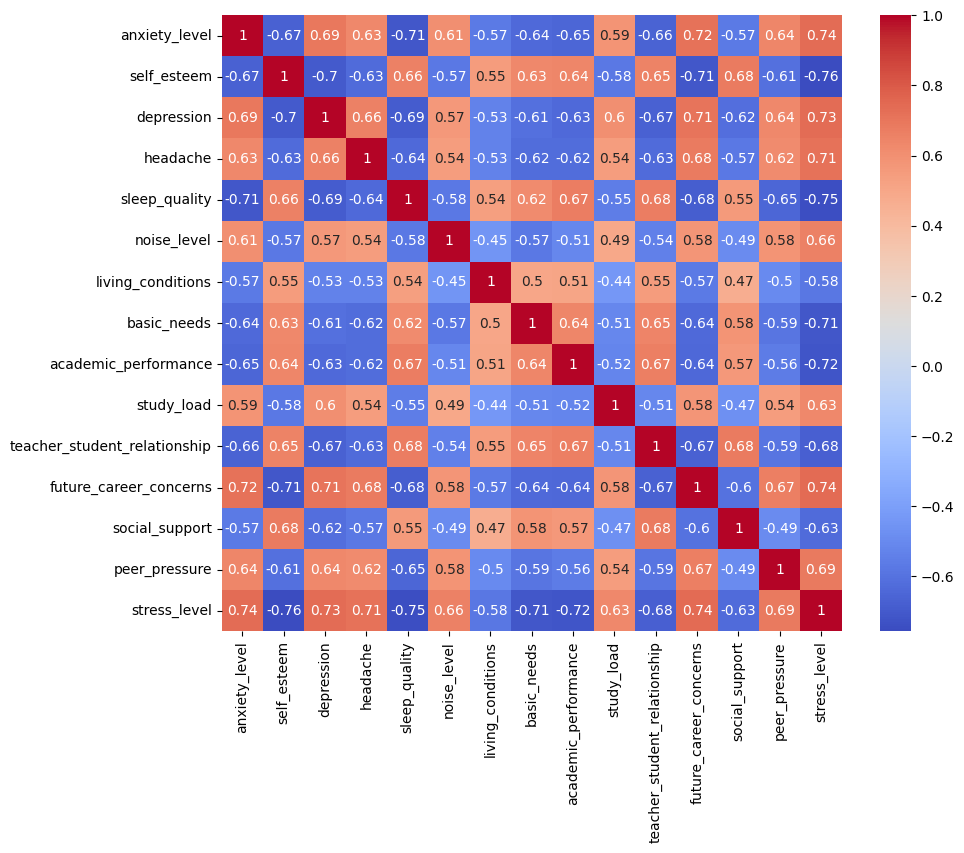

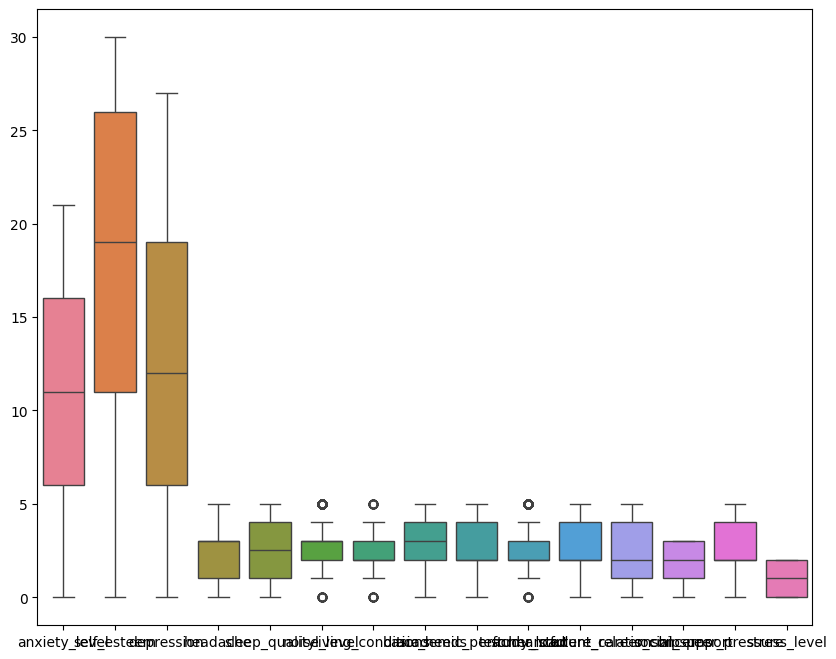

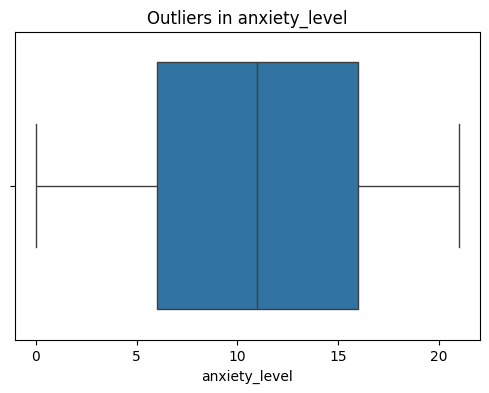

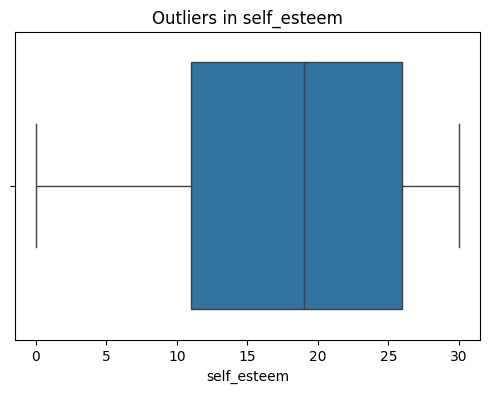

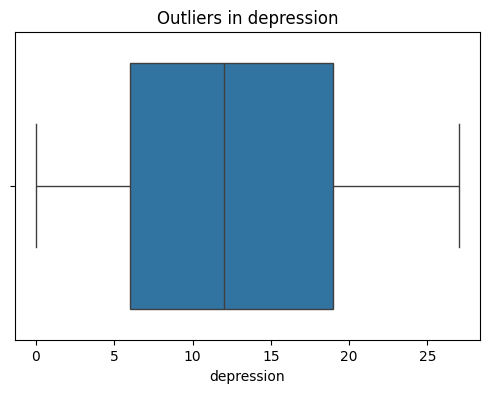

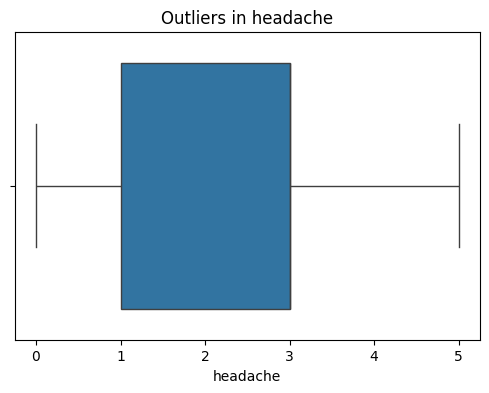

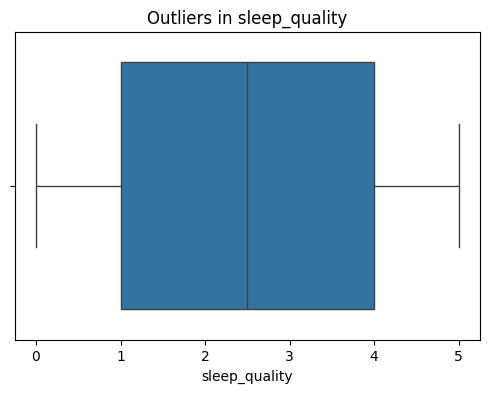

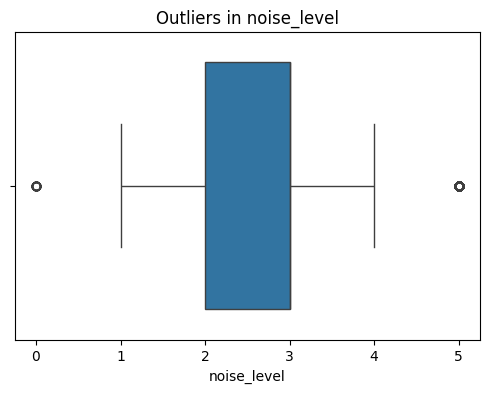

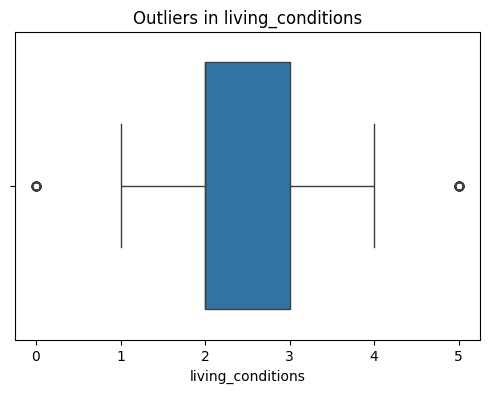

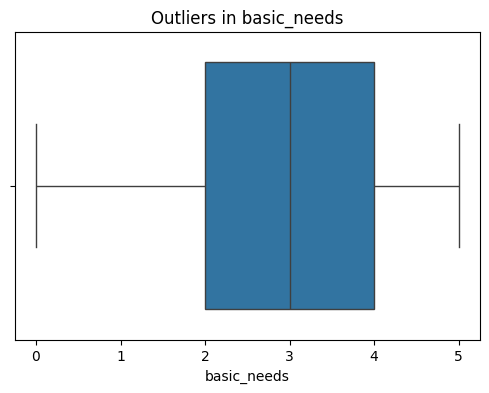

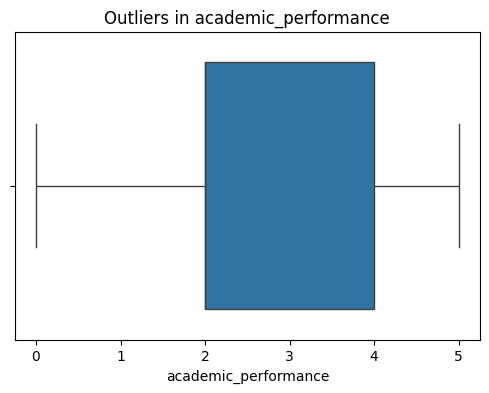

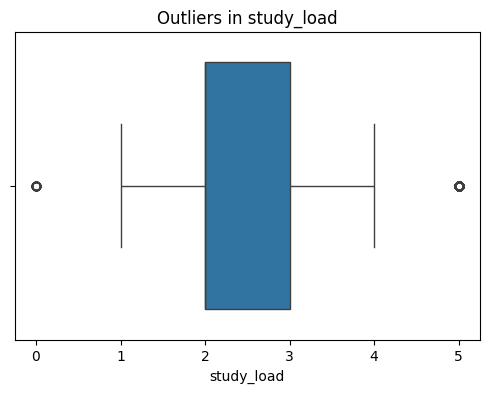

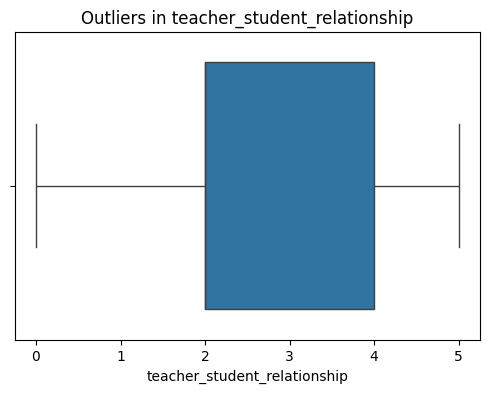

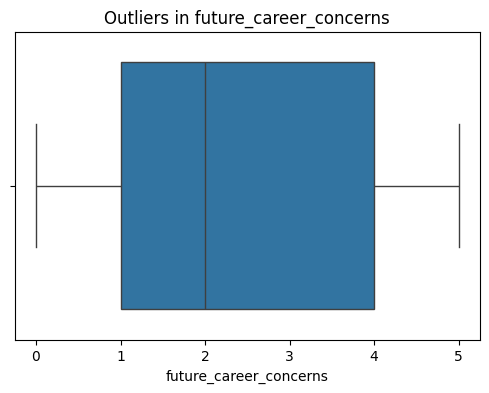

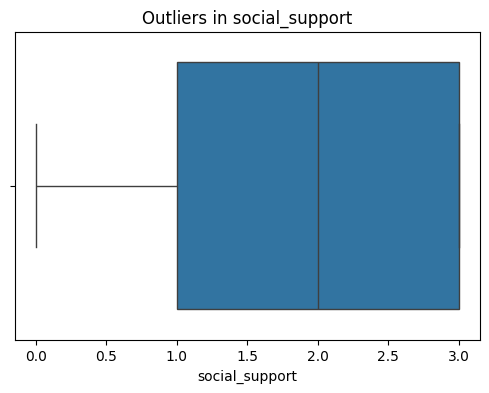

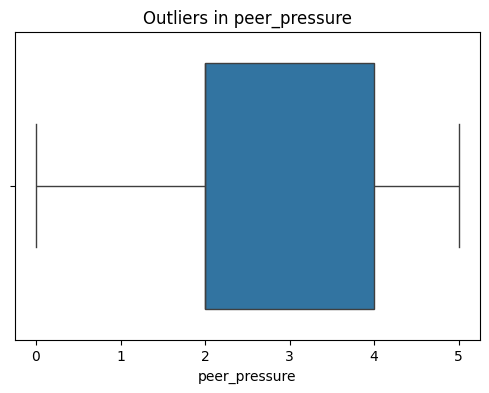

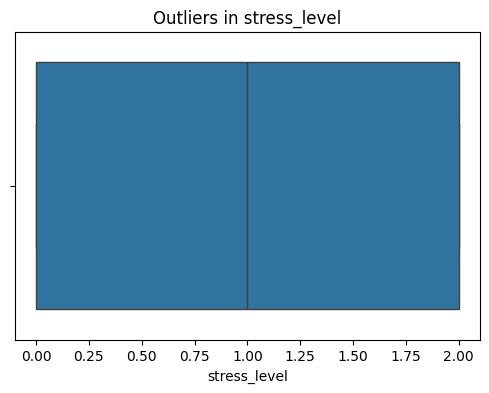

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("stress_factors.csv")

df = df.drop(columns=drop_cols, errors="ignore")
print(df.columns.tolist())

print(df.shape)
df.info()
print(df.describe())

print(df.isnull().sum())

df.hist(bins=20, figsize=(12,8))
plt.show()

print(df.isnull().sum())

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True,cmap="coolwarm")

plt.show()
plt.figure(figsize=(10,8))
sns.boxplot(data=df[['anxiety_level', 'self_esteem', 'depression', 'headache', 'sleep_quality', 'noise_level', 
                     'living_conditions', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship',
                     'future_career_concerns', 'social_support', 'peer_pressure', 'stress_level']])

plt.show()

for col in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Outliers in {col}")
    plt.show()

# 2) Create binary targets (auto, data-driven)

This creates target_psych, target_phys, target_env by aggregating related columns and binarizing using the median of that aggregated score (data-driven).

In [8]:
# Define groups (adjust if you want different mapping)
psych_cols = [c for c in ['anxiety_level','self_esteem','depression'] if c in df.columns]
phys_cols  = [c for c in ['headache','sleep_quality'] if c in df.columns]
social_cols  = [c for c in ['social_support','peer_pressure'] if c in df.columns]
env_cols   = [c for c in ['noise_level','living_conditions','safety','basic_needs'] if c in df.columns]
acad_cols  = [c for c in ['academic_performance','study_load','teacher_student_relationship','future_career_concerns'] if c in df.columns]

def make_target(group_cols, name):
    if not group_cols:
        return None
    # compute per-row mean of the group's columns (handles different scales)
    s = df[group_cols].mean(axis=1)
    thresh = s.median()  # data-driven threshold (you can change to a fixed value)
    df[name] = (s >= thresh).astype(int)
    return name

_ = make_target(psych_cols, 'target_psych')
_ = make_target(phys_cols,  'target_phys')
_ = make_target(social_cols,  'target_social')
_ = make_target(env_cols,   'target_env')
_ = make_target(acad_cols,   'target_acad')

targets = [c for c in ['target_psych','target_phys','target_social','target_env','target_acad'] if c in df.columns]
print("Targets created:", targets)
df[targets].head()


Targets created: ['target_psych', 'target_phys', 'target_social', 'target_env', 'target_acad']


,target_psych,target_phys,target_social,target_env,target_acad
0,1,0,1,0,1
1,0,1,1,0,1
2,1,0,1,0,0
3,1,1,1,1,1
4,1,1,1,1,0


# Train/Test Split

In [9]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("stress_factors.csv")

X = df.drop("stress_level", axis=1)
y = df["stress_level"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Evaluation and Prediction

In [10]:
# Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

y_predict = decision_tree_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_predict))
print("Confusion Matrics:\n ", confusion_matrix(y_test, y_predict))
print("Classification Report:\n ", classification_report(y_test, y_predict))


Accuracy:  0.8863636363636364
Confusion Matrics:
  [[68  5  3]
 [ 2 66  5]
 [ 5  5 61]]
Classification Report:
                precision    recall  f1-score   support

           0       0.91      0.89      0.90        76
           1       0.87      0.90      0.89        73
           2       0.88      0.86      0.87        71

    accuracy                           0.89       220
   macro avg       0.89      0.89      0.89       220
weighted avg       0.89      0.89      0.89       220



In [11]:
# Random Forest classifier applied
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

randomforest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
randomforest_model.fit(X_train, y_train)

y_predict_rf = randomforest_model.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_predict_rf))
print("Classification Report:\n", classification_report(y_test, y_predict_rf))


Random Forest Accuracy: 0.8727272727272727
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87        76
           1       0.90      0.86      0.88        73
           2       0.88      0.86      0.87        71

    accuracy                           0.87       220
   macro avg       0.87      0.87      0.87       220
weighted avg       0.87      0.87      0.87       220



In [12]:
# Logistic Regression applying here
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initializing model
logisticRegression = LogisticRegression(max_iter=1000, random_state=42)

# Train model
logisticRegression.fit(X_train, y_train)

# Predict
y_predictLogistic = logisticRegression.predict(X_test)

# Evaluate
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_predictLogistic))
print("Classification Report:\n", classification_report(y_test, y_predictLogistic))

Logistic Regression Accuracy:  0.8863636363636364
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        76
           1       0.88      0.89      0.88        73
           2       0.91      0.90      0.91        71

    accuracy                           0.89       220
   macro avg       0.89      0.89      0.89       220
weighted avg       0.89      0.89      0.89       220



In [17]:
# Applying the Support Vector Machine model here
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_model = SVC(kernel='linear', random_state=42)

# Train model
svm_model.fit(X_train, y_train)

# Predict
y_predictsvm = svm_model.predict(X_test)

# Evaluate
print("SVM Accuracy: ", accuracy_score(y_test, y_predictsvm))
print("\nClassification Report: \n", classification_report(y_test, y_predictsvm))
print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_predictsvm))


SVM Accuracy:  0.8909090909090909

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        76
           1       0.88      0.90      0.89        73
           2       0.91      0.89      0.90        71

    accuracy                           0.89       220
   macro avg       0.89      0.89      0.89       220
weighted avg       0.89      0.89      0.89       220


Confusion Matrix: 
 [[67  5  4]
 [ 5 66  2]
 [ 4  4 63]]


## Comparison

                      Model  Accuracy
0            Decision Tree   0.886364
1            Random Forest   0.872727
2      Logistic Regression   0.886364
3   Support Vector Machine   0.890909


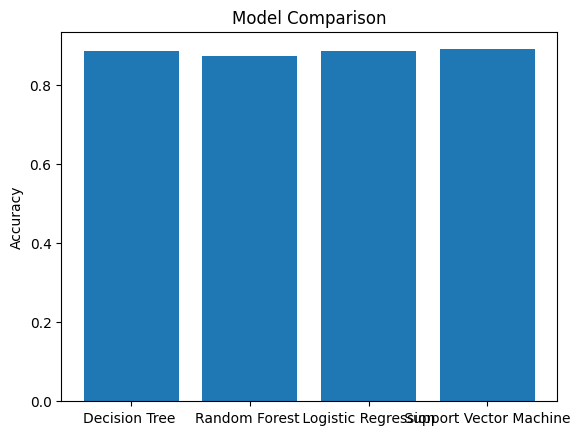

In [24]:
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Store results
results = {
    "Decision Tree ": decision_tree_model.score(X_test, y_test),
    "Random Forest ": randomforest_model.score(X_test, y_test),
    " Logistic Regression ": logisticRegression.score(X_test, y_test),
    " Support Vector Machine ": svm_model.score(X_test, y_test)
}

results_dataframe = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
print(results_dataframe)

plt.bar(results.keys(), results.values())
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()


# 3) Choose features (wearable-measurable / proxy)

Use only features that can be collected from wearables / phone sensors. If you also have raw high-frequency signals (HR, accel) you should create windowed summary features — I provide a short note below for that.

In [14]:
# Keep these if present
feature_candidates = [c for c in [
    'blood_pressure','sleep_quality','breathing_problem','noise_level',
    'headache','anxiety_level','depression','stress_level'  # careful: these might be labels; include only as features if you intend
] if c in df.columns]

# Typically, don't use anxiety/depression/stress as input features if they're your labels.
# So remove them from features if they appear in targets
for t in ['anxiety_level','depression','stress_level']:
    if t in feature_candidates and ('target_psych' in targets or 'target_env' in targets):
        feature_candidates.remove(t)

X = df[feature_candidates].copy()
y = df[targets].copy()

print("Features:", X.columns.tolist())
print("y shape:", y.shape)


Features: ['blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'headache']
y shape: (1100, 3)


# 4) Preprocess + model pipeline (baseline)

We’ll use a robust baseline: MultiOutputClassifier(RandomForest). Use GroupKFold if you have subject_id column — avoids leakage.

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.metrics import f1_score, hamming_loss, roc_auc_score

# Imputer & scaler (scaler optional for tree models)
preproc = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

X_prep = preproc.fit_transform(X)

clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42))

# Choose cross-validator: group-wise if possible
if 'subject_id' in df.columns:
    groups = df['subject_id']
    cv = GroupKFold(n_splits=5)
    preds = cross_val_predict(clf, X_prep, y, cv=cv, groups=groups, method='predict')
else:
    # fallback to 5-fold; for multi-label ideally use subject split or iterative stratification
    from sklearn.model_selection import StratifiedKFold
    # create a simple stratifier by first label (approx)
    strat_col = y.iloc[:,0] if y.shape[1]>0 else None
    cv = 5
    preds = cross_val_predict(clf, X_prep, y, cv=cv, method='predict')

preds = pd.DataFrame(preds, columns=y.columns, index=y.index)


# 5) Evaluation (multi-label metrics)

In [16]:
def eval_multi(y_true, y_pred):
    print("Hamming loss:", hamming_loss(y_true, y_pred))
    print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
    print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
    # per-label F1
    for col in y_true.columns:
        print(col, "F1:", f1_score(y_true[col], y_pred[col]))

eval_multi(y, preds)


Hamming loss: 0.07363636363636364
Micro F1: 0.9328543796628903
Macro F1: 0.9347678149556465
target_psych F1: 0.8170829975825947
target_phys F1: 0.987220447284345
target_env F1: 1.0


# 6) Better: predict probabilities + tune per-label threshold

Default threshold=0.5 is not always best. We'll get probabilities (with an actual train/val split) and choose threshold per label maximizing F1.

In [17]:


# train-test split (group-aware if possible)
if 'subject_id' in df.columns:
    # simple group split
    unique_groups = df['subject_id'].unique()
    train_groups, val_groups = train_test_split(unique_groups, test_size=0.2, random_state=42)
    train_idx = df['subject_id'].isin(train_groups)
    val_idx = df['subject_id'].isin(val_groups)
else:
    train_idx, val_idx = train_test_split(df.index, test_size=0.2, random_state=42)

X_tr, X_val = X_prep[train_idx], X_prep[val_idx]
y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

clf.fit(X_tr, y_tr)
probas = clf.predict_proba(X_val)  # list of arrays, one per label

# get best threshold per label
best_thresh = {}
y_pred_thresh = np.zeros_like(y_val.values)
for i, col in enumerate(y_val.columns):
    # predict_proba returns (n_samples, 2) for binary; take column 1
    p = probas[i][:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_val.iloc[:,i], p)
    f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-9)
    best_idx = np.nanargmax(f1_scores)
    # threshold array is one shorter than precisions; handle edge
    if best_idx >= len(thresholds):
        thr = 0.5
    else:
        thr = thresholds[best_idx]
    best_thresh[col] = float(thr)
    y_pred_thresh[:, i] = (p >= thr).astype(int)

y_pred_thresh = pd.DataFrame(y_pred_thresh, columns=y_val.columns, index=y_val.index)
eval_multi(y_val, y_pred_thresh)
print("Chosen thresholds per label:", best_thresh)


Hamming loss: 0.06666666666666667
Micro F1: 0.9385474860335196
Macro F1: 0.9458573172858887
target_psych F1: 0.8498168498168498
target_phys F1: 0.9877551020408163
target_env F1: 1.0
Chosen thresholds per label: {'target_psych': 0.14532842157842157, 'target_phys': 0.525, 'target_env': 0.935}
